In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import age_cal as ag
import cv2
import dlib
import imutils
import os
import joblib
from xgboost import XGBRegressor
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import pearsonr

In [ ]:
!pip install numpy
!pip install pandas
!pip install cvlib
!pip install opencv-python
!pip install imutils
!pip install tensorflow
!pip install joblib
!pip install dlib-19.24.99-cp312-cp312-win_amd64.whl
!pip install xgboost
!pip install catboost

In [11]:
#loading the data from csv
df = pd.read_csv("./dataset/csv/real_person.csv")

new_df = df[["name","date_of_birth","weight","sex","height"]]

initial_len = len(new_df)

#removing the rows with empty values
new_df.dropna(inplace=True)

final_len = len(new_df)

print(f"No of data removed:{initial_len - final_len}")

new_df

No of data removed:397


C:\Users\veere\AppData\Local\Temp\ipykernel_1812\3580997671.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.dropna(inplace=True)


,name,date_of_birth,weight,sex,height
A00147,JOHN,06/14/1949,185.0,Male,67.0
A00220,ISIAH,03/30/1957,155.0,Male,73.0
A00360,HOWARD,12/18/1946,167.0,Male,69.0
A00367,RAYMOND,01/12/1954,245.0,Male,72.0
A01054,DARNELL,03/25/1954,166.0,Male,67.0
...,...,...,...,...,...
Y25362,ERIC A.,05/30/1985,120.0,Male,59.0
Y25363,JEFFERY D.,05/15/1986,170.0,Male,71.0
Y25364,KIMBERLY D.,02/23/1972,112.0,Female,62.0
Y25365,KARLEE R.,06/16/1992,158.0,Female,63.0


In [13]:
import importlib

importlib.reload(ag)
#calculating the age of the person
new_df['Age'] = new_df['date_of_birth'].apply(ag.calculate_age)

new_df['height'] = new_df['height'] * 0.0254  # converts height to meters
new_df['weight'] = new_df['weight'] * 0.4536  # converts weight to kgs

new_df['BMI'] = new_df.apply(lambda row: ag.calculate_bmi(row['height'], row['weight']), axis=1)

new_df

C:\Users\veere\AppData\Local\Temp\ipykernel_1812\3633578971.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Age'] = new_df['date_of_birth'].apply(ag.calculate_age)
C:\Users\veere\AppData\Local\Temp\ipykernel_1812\3633578971.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['height'] = new_df['height'] * 0.0254  # converts height to meters
C:\Users\veere\AppData\Local\Temp\ipykernel_1812\3633578971.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

,name,date_of_birth,weight,sex,height,Age,BMI
A00147,JOHN,06/14/1949,83.9160,Male,1.7018,75,28.975286
A00220,ISIAH,03/30/1957,70.3080,Male,1.8542,67,20.449919
A00360,HOWARD,12/18/1946,75.7512,Male,1.7526,77,24.661751
A00367,RAYMOND,01/12/1954,111.1320,Male,1.8288,70,33.228191
A01054,DARNELL,03/25/1954,75.2976,Male,1.7018,70,25.999446
...,...,...,...,...,...,...,...
Y25362,ERIC A.,05/30/1985,54.4320,Male,1.4986,39,24.237222
Y25363,JEFFERY D.,05/15/1986,77.1120,Male,1.8034,38,23.710343
Y25364,KIMBERLY D.,02/23/1972,50.8032,Female,1.5748,52,20.485202
Y25365,KARLEE R.,06/16/1992,71.6688,Female,1.6002,32,27.988627


In [7]:
#extracting facial features from the image using a pretrained model
# Load the pre-trained facial landmarks model
landmark_model_path = "pretrained_models/shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(landmark_model_path)

def extract_landmarks(image_path):
    # Read the image
    image = cv2.imread(image_path)
    image = imutils.resize(image, width=600)

    if image is None:
        print("Hello")

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image
    faces = detector(gray)
    if len(faces) == 0:
        print("No faces detected!")
        return None

    # Assume the first face detected is the target face
    landmarks = predictor(gray, faces[0])

    # Extract (x, y) coordinates of the landmarks
    points = []
    for n in range(68):
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        points.append((x, y))

    return points

def compute_features(front_landmarks, side_landmarks=None):
    # Cheek-to-Jaw Width Ratio (CJWR)
    jaw_width = np.linalg.norm(np.array(front_landmarks[3]) - np.array(front_landmarks[13]))
    cheek_width = np.linalg.norm(np.array(front_landmarks[1]) - np.array(front_landmarks[15]))
    cjwr = cheek_width / jaw_width

    # Width to Upper Facial Height Ratio (WHR)
    width = np.linalg.norm(np.array(front_landmarks[1]) - np.array(front_landmarks[15]))
    upper_height = np.linalg.norm(np.array(front_landmarks[27]) - np.array(front_landmarks[8]))
    whr = width / upper_height

    # Perimeter to Area Ratio (PAR)
    contour_points = np.array(front_landmarks[:17])  # Jawline points
    perimeter = cv2.arcLength(contour_points, True)
    area = cv2.contourArea(contour_points)
    par = perimeter / area if area != 0 else None

    # Eye Size (ES)
    left_eye_width = np.linalg.norm(np.array(front_landmarks[36]) - np.array(front_landmarks[39]))
    left_eye_height = np.linalg.norm(np.array(front_landmarks[37]) - np.array(front_landmarks[41]))
    right_eye_width = np.linalg.norm(np.array(front_landmarks[42]) - np.array(front_landmarks[45]))
    right_eye_height = np.linalg.norm(np.array(front_landmarks[43]) - np.array(front_landmarks[47]))
    es = ((left_eye_width * left_eye_height) + (right_eye_width * right_eye_height)) / 2

    # Lower Face to Face Height Ratio (FW/FH)
    lower_face_height = np.linalg.norm(np.array(front_landmarks[33]) - np.array(front_landmarks[8]))
    face_height = np.linalg.norm(np.array(front_landmarks[27]) - np.array(front_landmarks[8]))
    fw_fh = lower_face_height / face_height

    # Mean Eyebrow Height (MEH)
    left_eyebrow_mean_height = np.mean([np.linalg.norm(np.array(front_landmarks[19]) - np.array(front_landmarks[37])),
                                        np.linalg.norm(np.array(front_landmarks[20]) - np.array(front_landmarks[38]))])
    right_eyebrow_mean_height = np.mean([np.linalg.norm(np.array(front_landmarks[23]) - np.array(front_landmarks[43])),
                                         np.linalg.norm(np.array(front_landmarks[24]) - np.array(front_landmarks[44]))])
    meh = (left_eyebrow_mean_height + right_eyebrow_mean_height) / 2

    return {
        "CJWR": cjwr,
        "WHR": whr,
        "PAR": par,
        "ES": es,
        "FW/FH": fw_fh,
        "MEH": meh
    }

# Example usage
front_photo_path = "A00147_front.jpg"

front_landmarks = extract_landmarks(front_photo_path)
if front_landmarks:
    features = compute_features(front_landmarks)
    print("Computed Facial Features:")
    for key, value in features.items():
        print(f"{key}: {value}") 


Computed Facial Features:
CJWR: 1.081183738441964
WHR: 1.0675000749332786
PAR: 0.018273272652999176
ES: 411.32839005057497
FW/FH: 0.6458625098059632
MEH: 32.65681192401898


In [9]:
# compute the frontal and side wise facial features for each entry and add this to the dataframe

cols = ['front_CJWR', 'front_WHR', 'front_PAR', 'front_ES', 'front_FW/FH', 'front_MEH', 'side_CJWR', 'side_WHR', 'side_PAR', 'side_ES', 'side_FW/FH', 'side_MEH']

for c in cols:
    new_df[c] = 0

C:\Users\veere\AppData\Local\Temp\ipykernel_2396\4018788968.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df[c] = 0
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\4018788968.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df[c] = 0
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\4018788968.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:/

In [13]:
# calculating the face features for every row and strorign it in the dataframe
index_values = new_df.index.tolist()

path = './dataset/front/front/'

j = 0

for i in index_values:
    file_path = path + i + ".jpg"

    if(os.path.exists(file_path)):
        
        landmarks = extract_landmarks(file_path)
        if landmarks is None:
            print(i)
            new_df.drop(i, inplace = True)
            continue
        
        features = compute_features(landmarks)
        
        
        new_df.loc[i, "front_CJWR"] = features["CJWR"]
        new_df.loc[i, "front_WHR"] = features["WHR"]
        new_df.loc[i, "front_PAR"] = features["PAR"]
        new_df.loc[i, "front_ES"] = features["ES"]
        new_df.loc[i, "front_FW/FH"] = features["FW/FH"]
        new_df.loc[i, "front_MEH"] = features["MEH"]
    else:
        new_df.drop(i, inplace = True)

    j += 1
    if(j%5000)==0:
        print(i)

C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.081183738441964' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  new_df.loc[i, "front_CJWR"] = features["CJWR"]
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.0675000749332786' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  new_df.loc[i, "front_WHR"] = features["WHR"]
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.018273272652999176' has dtype incompatible with int64, please explicitly cast to a compatible dtype f

No faces detected!
A02306


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
A02376


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
A10157


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
A10508


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
A10913


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
A15580


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
A50207


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
A50324


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
A51054


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
A61010


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
A62278


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
A63742


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
A64284


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
A68718


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
A70170


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
A70208


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
A70983


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
A71068


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
A71429


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
A73555


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
A74143


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
A80442


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
A80582


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
A82092


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
A83084


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
A83405


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
A87924


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
A90240


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
A90485


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
A91250


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
A91584


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
A92280


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
A95046


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
A96072


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B00659


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B03191


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B04516


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B04962


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B05036


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B05409


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B05972


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B08169


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B08694


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B09025


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B09641


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B11390


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B12010


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B12029


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B12095


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B12871


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B13365


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B15636


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B16364


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B17233


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B18419


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B20290


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B20449


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\User

No faces detected!
B23456


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B23771


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B23924


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B27295


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B27763


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B31040


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B32229


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B34441


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B34504


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B34589


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B36110


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B36250


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B36789


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B36900


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B38219


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B38443


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B38560


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B39231


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B39580


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\User

No faces detected!
B42255


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B42599


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\User

No faces detected!
B44107


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B44440


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B44617


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B44739


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B45285


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B45533


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B45891


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B52291


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


B52357


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B52935


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B53712


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B54318


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B54680


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B54894


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B57493


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B60430


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B61764


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B62273


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B63217


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B63749


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B64881


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B65618


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B67279


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B68318


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B68750


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B69219


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B71049


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B71273


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B71382


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B71913


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B72300


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B74881


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B75533


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B77269


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B79178


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B79731


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B80129


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B81446


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B81852


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B83855


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B84769


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B85023


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B85145


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B86777


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B88488


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
B89068


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\User

No faces detected!
C01441


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
C01563


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\User

No faces detected!
C61229
No faces detected!
C61397


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\User

No faces detected!
K03093


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


K03501
No faces detected!
K03795


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
K04244


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
K50075


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
K50298


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
K51273


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
K51616


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
K58447


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
K58649


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
K59841


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
K60141


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
K63585


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
K63860


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
K65746


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
K66152


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
K68116


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
K69117


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
K69335


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
K72428


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
K73314


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
K76895


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
K77013


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
K77375


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
K77576


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
K79532


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
K80385


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
K82049


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
K92214


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


K97307
No faces detected!
K98084


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
L11790
No faces detected!
L13943


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
M01383


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
M03916


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
M06483


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
M07391


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
M10974


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
M14505


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
M20643


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


M22278


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
M31584


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
M31670


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
M33514


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\User

No faces detected!
M40122


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
M40863


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


M41028


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
M41849


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
M43458


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
M45722


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
M47608


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
M47760


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
M48266


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
M48312


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
M53166


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\User

No faces detected!
M55093


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


M55197
No faces detected!
M55377


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
N00789


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
N01022


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
N01540


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
N01605


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
N01953


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
N02654


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
N03207


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
N03454


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
N03651


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
N04185


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
N07925


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
N08328


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
N10255


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
N11308


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
N12367


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
N13286


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
N13696


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
N14003


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
N18206


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
N20367


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
N20630


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
N20653


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
N22524
No faces detected!
N23082


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
N23774


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
N24071


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
N24337


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
N26330


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
N30479


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
N30898


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
N33179


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
N33216


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
N36426


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
N37959


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
N42236


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
N43373


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
N46054


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
N50331


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
N50865


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
N52129


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
N52173


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
N53301


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
N53853


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
N54188


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
N57551


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
N60199


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
N60672


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\User

No faces detected!
N61990


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
N62588


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
N63173
No faces detected!
N63185


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
N63220


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
N63319


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
N64546


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
N70015


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
N70037


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
N70919


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
N71856


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
N72682


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
N73898


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
N74141


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
N74376


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
N80132


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
N80318


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
N81412


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
N82954


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
N83637


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
N84640


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
N84752


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
N87843


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
N93165


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
N93177


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
N93258


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\User

No faces detected!
N96236


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
N98639


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
R02652


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
R03506


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
R03596


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
R04045


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
R07170


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


R08777
No faces detected!
R10086


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
R10952


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
R13554


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
R18798


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
R23770


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
R25029


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
R26264


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
R26981


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
R29598


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
R30285


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
R40790


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
R45713


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


R48670
No faces detected!
R52598


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
R53025


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
R57662


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
R58464


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
R61848


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
R62298


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
R68950


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
R72813


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
R73496


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


R86954


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\User

No faces detected!
S02141


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
S03775


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
S09094


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
S10861


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
S13167


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
S14368


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
S15769


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
S16609


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\User

No faces detected!
X69626


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\User

X70108


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\User

No faces detected!
X77079
No faces detected!
X77101


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\User

No faces detected!
X77321


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\User

No faces detected!
X77796


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\User

No faces detected!
X77981


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\User

No faces detected!
X78073


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
X78109


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\User

No faces detected!
X78148


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\User

No faces detected!
X78675


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\User

No faces detected!
Y11415


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
Y12701


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\User

No faces detected!
Y15035


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
Y16001


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\User

Y17901


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
Y19457


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\User

No faces detected!
Y21260


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
Y21490


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
Y21978


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
Y22493


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
Y22814


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
Y23785


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
Y23986


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


No faces detected!
Y24109


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


Y24904


C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)
C:\Users\veere\AppData\Local\Temp\ipykernel_2396\2331754724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(i, inplace = True)


In [15]:
new_df

,name,date_of_birth,weight,sex,height,Age,BMI,front_CJWR,front_WHR,front_PAR,front_ES,front_FW/FH,front_MEH,side_CJWR,side_WHR,side_PAR,side_ES,side_FW/FH,side_MEH
A00147,JOHN,06/14/1949,83.9160,Male,1.7018,75,28.975286,1.081184,1.067500,0.018273,411.328390,0.645863,32.656812,0,0,0,0,0,0
A00360,HOWARD,12/18/1946,75.7512,Male,1.7526,77,24.661751,1.047824,1.103064,0.016494,661.834712,0.603112,24.169231,0,0,0,0,0,0
A00367,RAYMOND,01/12/1954,111.1320,Male,1.8288,70,33.228191,1.070976,1.154339,0.019990,532.738514,0.590059,35.839677,0,0,0,0,0,0
A01054,DARNELL,03/25/1954,75.2976,Male,1.7018,70,25.999446,1.088111,1.052656,0.019419,524.563409,0.614282,49.145540,0,0,0,0,0,0
A01072,HENRY,01/12/1956,88.4520,Male,1.7526,68,28.796655,1.022147,1.126713,0.021241,442.251622,0.617723,36.512676,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Y25362,ERIC A.,05/30/1985,54.4320,Male,1.4986,39,24.237222,1.111390,1.186808,0.024855,319.324334,0.556658,28.804683,0,0,0,0,0,0
Y25363,JEFFERY D.,05/15/1986,77.1120,Male,1.8034,38,23.710343,1.088257,1.183429,0.019662,685.103107,0.605598,29.721877,0,0,0,0,0,0
Y25364,KIMBERLY D.,02/23/1972,50.8032,Female,1.5748,52,20.485202,1.131558,1.328892,0.024238,326.558847,0.496600,23.286076,0,0,0,0,0,0
Y25365,KARLEE R.,06/16/1992,71.6688,Female,1.6002,32,27.988627,1.093578,1.111250,0.022042,270.270653,0.603141,34.712673,0,0,0,0,0,0


In [1]:
new_df.to_csv('output.csv', index=False) #saving the dataframe

NameError: name 'new_df' is not defined

In [4]:
#extracting the data for model training from the saved face features and gender
data = pd.read_csv('output.csv')
total_datax = data[['front_CJWR', 'front_WHR', 'front_PAR', 'front_ES', 'front_FW/FH', 'front_MEH']]
total_datax['sex'] = data['sex'].map({'Male': 0, 'Female': 1})
total_datax

total_datay = data[['BMI']]

total_datay

C:\Users\veere\AppData\Local\Temp\ipykernel_19768\3161354992.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_datax['sex'] = data['sex'].map({'Male': 0, 'Female': 1})


,BMI
0,28.975286
1,24.661751
2,33.228191
3,25.999446
4,28.796655
...,...
59672,24.237222
59673,23.710343
59674,20.485202
59675,27.988627


In [6]:
X_train, X_test, y_train, y_test = train_test_split(total_datax, total_datay, test_size=0.2, random_state=42)

In [8]:
#Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
print("Linear Regression:")
y_test = y_test.squeeze()  # Converts a DataFrame with one column into a Series
y_pred = y_pred.squeeze()
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
pearson_corr, _ = pearsonr(y_test, y_pred)
print("Pearson Correlation Coefficient:", pearson_corr)
tolerance = 5  # Define a tolerance value

# Calculate percentage of predictions within the tolerance
accuracy = (np.abs(y_test - y_pred) <= tolerance).mean() * 100
print(f"Prediction Accuracy within ±{tolerance} units: {accuracy}")

# Save the model
joblib.dump(lr, './models/linear_reg.pkl')

Linear Regression:
MSE: 22.8019888114475
R2 Score: 0.15931243048993748
Mean Absolute Error: 3.6314003254255875
Pearson Correlation Coefficient: 0.39922100624894363
Prediction Accuracy within ±5 units: 74.57272117962466


['./models/linear_reg.pkl']

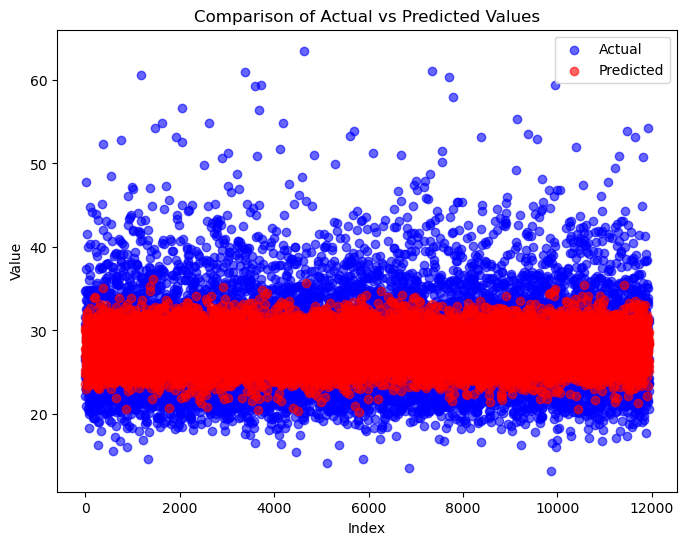

In [10]:
# Example: Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(range(len(y_test)), y_test, label="Actual", color="blue", alpha=0.6)
plt.scatter(range(len(y_pred)), y_pred, label="Predicted", color="red", alpha=0.6)

# print(y_pred)
# print(y_test)

plt.title('Comparison of Actual vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

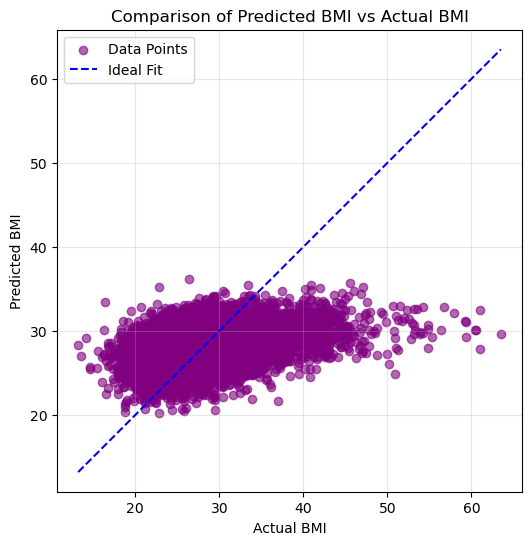

In [14]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, color="purple", alpha=0.6, label="Data Points")

# Add the ideal fit line (y = x) with a dotted style
min_val = min(min(y_test), min(y_pred))  # Determine the minimum value in both datasets
max_val = max(max(y_test), max(y_pred))  # Determine the maximum value in both datasets
plt.plot([min_val, max_val], [min_val, max_val], linestyle="--", color="blue", label="Ideal Fit")

plt.title('Comparison of Predicted BMI vs Actual BMI')
plt.ylabel('Predicted BMI')
plt.xlabel('Actual BMI')
plt.axis("equal")  # Ensures equal scaling on both axes
plt.grid(alpha=0.3)
plt.legend()  # Add a legend to distinguish between the scatter points and the ideal fit line
plt.show()


In [54]:
#XGBRegression
xgb = XGBRegressor(random_state=42)
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
y_test = y_test.squeeze()  # Converts a DataFrame with one column into a Series
y_pred = y_pred.squeeze()
print("XGBRegression")
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
pearson_corr, _ = pearsonr(y_test, y_pred)
print("Pearson Correlation Coefficient:", pearson_corr)

tolerance = 5  # Define a tolerance value


# Calculate percentage of predictions within the tolerance
accuracy = (np.abs(y_test - y_pred) <= tolerance).mean() * 100
print(f"Prediction Accuracy within ±{tolerance} units: {accuracy}")

joblib.dump(xgb, './models/XGB_regg.pkl')


XGBRegression
MSE: 23.51615758087907
R2 Score: 0.13298170943055343
Mean Absolute Error: 3.68148471597057
Pearson Correlation Coefficient: 0.37497722131696176
Prediction Accuracy within ±5 units: 74.11193029490617


['./models/XGB_regg.pkl']

In [16]:
#Catboost regression

# Initialize CatBoost Regressor
model = CatBoostRegressor(iterations=1000, 
                           learning_rate=0.1, 
                           depth=6, 
                           loss_function='RMSE', 
                           verbose=100)

# Fit the model
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

y_test = y_test.squeeze()  # Converts a DataFrame with one column into a Series
y_pred = y_pred.squeeze()
print("Catboost regression")
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
pearson_corr, _ = pearsonr(y_test, y_pred)
print("Pearson Correlation Coefficient:", pearson_corr)

tolerance = 5  # Define a tolerance value
# Calculate percentage of predictions within the tolerance
accuracy = (np.abs(y_test - y_pred) <= tolerance).mean() * 100
print(f"Prediction Accuracy within ±{tolerance} units: {accuracy}")

joblib.dump(model, './models/cat_reg.pkl')

0:	learn: 5.1426077	total: 162ms	remaining: 2m 41s
100:	learn: 4.6773455	total: 1.06s	remaining: 9.48s
200:	learn: 4.6165422	total: 1.94s	remaining: 7.73s
300:	learn: 4.5666537	total: 2.83s	remaining: 6.56s
400:	learn: 4.5218344	total: 3.7s	remaining: 5.53s
500:	learn: 4.4796664	total: 4.55s	remaining: 4.53s
600:	learn: 4.4407687	total: 5.42s	remaining: 3.6s
700:	learn: 4.4038743	total: 6.29s	remaining: 2.68s
800:	learn: 4.3671816	total: 7.18s	remaining: 1.78s
900:	learn: 4.3322825	total: 8.06s	remaining: 886ms
999:	learn: 4.2988887	total: 8.97s	remaining: 0us
Catboost regression
MSE: 22.762079606613884
R2 Score: 0.16078384479024654
Mean Absolute Error: 3.6257049309024314
Pearson Correlation Coefficient: 0.4025201389864793
Prediction Accuracy within ±5 units: 74.93297587131367


['./models/cat_reg.pkl']

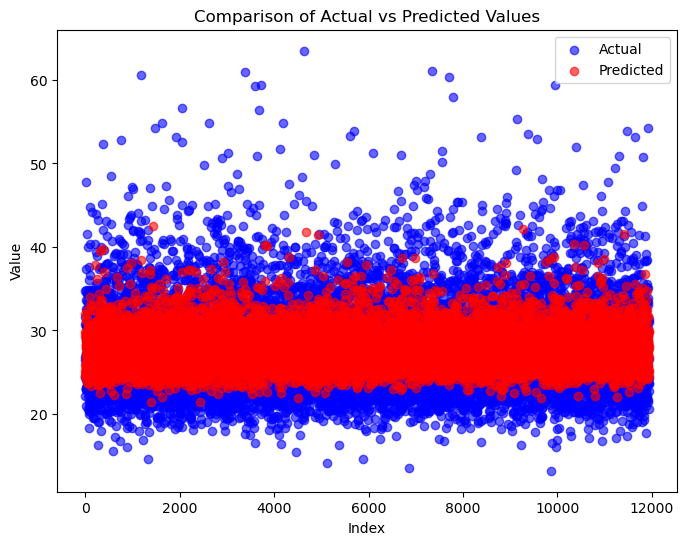

In [17]:
# Example: Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(range(len(y_test)), y_test, label="Actual", color="blue", alpha=0.6)
plt.scatter(range(len(y_pred)), y_pred, label="Predicted", color="red", alpha=0.6)

# print(y_pred)
# print(y_test)

plt.title('Comparison of Actual vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

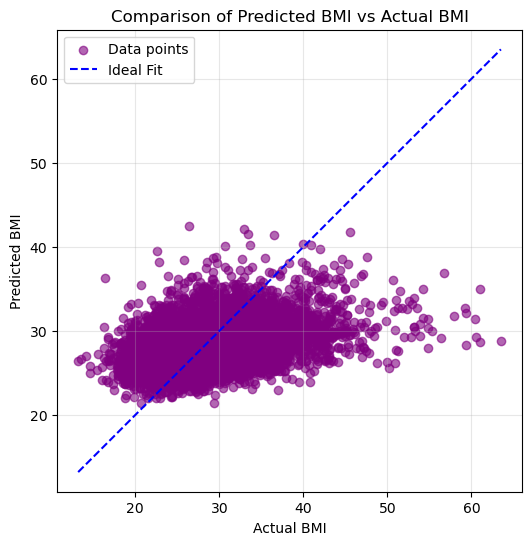

In [24]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, color="purple", alpha=0.6, label="Data points")

# Add the ideal fit line (y = x) with a dotted style
min_val = min(min(y_test), min(y_pred))  # Determine the minimum value in both datasets
max_val = max(max(y_test), max(y_pred))  # Determine the maximum value in both datasets
plt.plot([min_val, max_val], [min_val, max_val], linestyle="--", color="blue", label="Ideal Fit")

plt.title('Comparison of Predicted BMI vs Actual BMI')
plt.ylabel('Predicted BMI')
plt.xlabel('Actual BMI')
plt.axis("equal")  # Ensures equal scaling on both axes
plt.grid(alpha=0.3)
plt.legend()
plt.show()

In [36]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd

scaler = StandardScaler()
X_scaled = scaler.fit_transform(total_datax)

# Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_scaled)

# Convert to DataFrame for easier plotting
X_pca_df = pd.DataFrame(X_pca)

# # Plot the first two principal components
# plt.figure(figsize=(8, 6))
# plt.scatter(X_pca_df['PC1'], X_pca_df['PC2'], c='blue', alpha=0.5)
# plt.title('PCA - 2D Projection')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.show()

# # Print the explained variance
# explained_variance = pca.explained_variance_ratio_
# print(f"Explained variance by PC1: {explained_variance[0]:.2f}")
# print(f"Explained variance by PC2: {explained_variance[1]:.2f}")


In [38]:
X_train, X_test, y_train, y_test = train_test_split(X_pca_df, total_datay, test_size=0.2, random_state=42)

In [40]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
print("Linear Regression:")
y_test = y_test.squeeze()  # Converts a DataFrame with one column into a Series
y_pred = y_pred.squeeze()
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
pearson_corr, _ = pearsonr(y_test, y_pred)
print("Pearson Correlation Coefficient:", pearson_corr)

tolerance = 5  # Define a tolerance value


# Calculate percentage of predictions within the tolerance
accuracy = (np.abs(y_test - y_pred) <= tolerance).mean() * 100
print(f"Prediction Accuracy within ±{tolerance} units: {accuracy}")


Linear Regression:
MSE: 23.78019864758948
R2 Score: 0.1232467672525196
Mean Absolute Error: 3.7177564647205967
Pearson Correlation Coefficient: 0.35122865853805085
Prediction Accuracy within ±5 units: 73.3411528150134


In [42]:
from xgboost import XGBRegressor

xgb = XGBRegressor(random_state=42)
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
print("XGBoost Regression:")
y_test = y_test.squeeze()  # Converts a DataFrame with one column into a Series
y_pred = y_pred.squeeze()
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
pearson_corr, _ = pearsonr(y_test, y_pred)
print("Pearson Correlation Coefficient:", pearson_corr)

tolerance = 5  # Define a tolerance value


# Calculate percentage of predictions within the tolerance
accuracy = (np.abs(y_test - y_pred) <= tolerance).mean() * 100
print(f"Prediction Accuracy within ±{tolerance} units: {accuracy}")


XGBoost Regression:
MSE: 24.48357891503236
R2 Score: 0.09731380796692313
Mean Absolute Error: 3.766189311595829
Pearson Correlation Coefficient: 0.32575238323021816
Prediction Accuracy within ±5 units: 73.13170241286863


In [44]:
# Initialize CatBoost Regressor
model = CatBoostRegressor(iterations=1000,
                           learning_rate=0.1, 
                           depth=6, 
                           loss_function='RMSE', 
                           verbose=100)

# Fit the model
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

y_test = y_test.squeeze()  # Converts a DataFrame with one column into a Series
y_pred = y_pred.squeeze()
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
pearson_corr, _ = pearsonr(y_test, y_pred)
print("Pearson Correlation Coefficient:", pearson_corr)

tolerance = 5  # Define a tolerance value


# Calculate percentage of predictions within the tolerance
accuracy = (np.abs(y_test - y_pred) <= tolerance).mean() * 100
print(f"Prediction Accuracy within ±{tolerance} units: {accuracy}")

0:	learn: 5.1410529	total: 11.7ms	remaining: 11.7s
100:	learn: 4.7975000	total: 835ms	remaining: 7.43s
200:	learn: 4.7520370	total: 1.66s	remaining: 6.58s
300:	learn: 4.7118202	total: 2.47s	remaining: 5.73s
400:	learn: 4.6761213	total: 3.26s	remaining: 4.87s
500:	learn: 4.6437905	total: 4.08s	remaining: 4.07s
600:	learn: 4.6139996	total: 4.89s	remaining: 3.25s
700:	learn: 4.5850339	total: 5.67s	remaining: 2.42s
800:	learn: 4.5578975	total: 6.45s	remaining: 1.6s
900:	learn: 4.5312342	total: 7.24s	remaining: 796ms
999:	learn: 4.5065663	total: 8.04s	remaining: 0us
MSE: 23.866620881419514
R2 Score: 0.1200604619564778
Mean Absolute Error: 3.7151543002432668
Pearson Correlation Coefficient: 0.3492261835724804
Prediction Accuracy within ±5 units: 73.76843163538874


## print(X_test)

In [59]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(total_datax)

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, total_datay, test_size=0.2, random_state=42)

In [63]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
print("Linear Regression:")
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))
tolerance = 5  # Define a tolerance value

# Calculate percentage of predictions within the tolerance
accuracy = (np.abs(y_test - y_pred) <= tolerance).mean() * 100
print(f"Prediction Accuracy within ±{tolerance} units: {accuracy.BMI}")

import joblib

# Save the model
joblib.dump(lr, 'linear_reg.pkl')

Linear Regression:
MSE: 23.6406993628755
R2 Score: 0.1283899727678084
Prediction Accuracy within ±5 units: 74.32138069705094


['linear_reg.pkl']

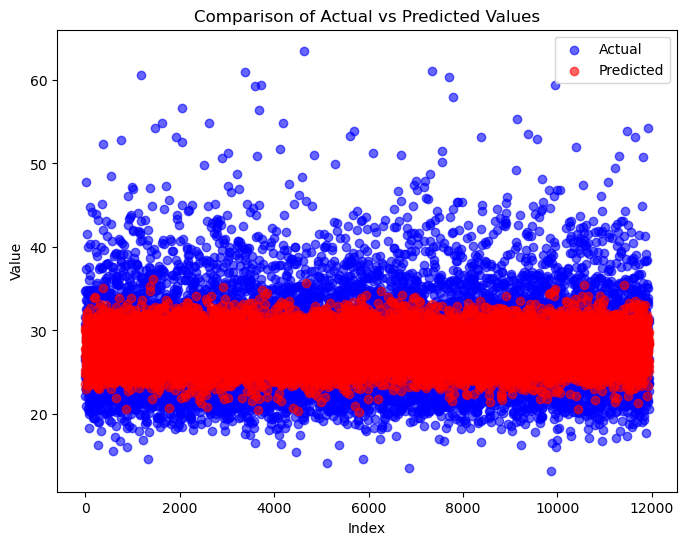

In [23]:
import matplotlib.pyplot as plt

# Example: Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(range(len(y_test)), y_test, label="Actual", color="blue", alpha=0.6)
plt.scatter(range(len(y_pred)), y_pred, label="Predicted", color="red", alpha=0.6)

plt.title('Comparison of Actual vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()


In [11]:
print(len(y_pred))
print(len(y_test))

11936
11936
